In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)
import cf_xarray
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import polars as pl
import pandas as pd
import pprint
import string
import os
import sys
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import scienceplots
plt.style.use(["nature", "notebook"])
%load_ext rich

In [2]:
results_dir = os.getcwd()+'/Results/'
fig_dir = os.getcwd()+'/Figures/'

## Coerce to xarray dataset

In [26]:
from DLEMinputs import create_interpolation_grid
ncols, nrows, lons, lats, no_data_value = create_interpolation_grid()

In [135]:
for crop in tqdm(['corn', 'soybean']):
    dlem_files = sorted(glob(results_dir+f'DLEM/{crop}_production/{crop.capitalize()}*.bin'))
    cesm_files = sorted(glob(results_dir+f'CESM2/{crop}_production/{crop.capitalize()}*.bin'))
    xrs = []
    for i, y in enumerate(range(1970, 2010)):
        dlem_np = np.fromfile(dlem_files[i], dtype=np.float32).reshape([292, 693])[np.newaxis, :, :]
        cesm_np = np.fromfile(cesm_files[i], dtype=np.float32).reshape([292, 693])[np.newaxis, :, :]
        dlem_np = np.where(dlem_np == 0, np.nan, dlem_np)
        cesm_np = np.where(cesm_np == 0, np.nan, cesm_np)
        # Create the xarray dataset
        dlem_xr = xr.Dataset(
            {
                f'DLEM': (['time', 'lat', 'lon'], dlem_np),
                f'CESM2': (['time', 'lat', 'lon'], cesm_np),
            },
            coords={
                'time': np.atleast_1d(pd.to_datetime(y, format='%Y')),
                'lat': lats,
                'lon': lons
            },
            attrs={
                'units': 'kg'
            }
        )
        xrs.append(dlem_xr)
    # Concatenate the datasets
    xrs = xr.concat(xrs, dim='time')
    # Save the dataset
    xrs.to_netcdf(results_dir+f'{crop}_production.nc')
    

100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


## Plots

In [3]:
corn = xr.load_dataset('Results/corn_production.nc')
corn = corn.where(corn['CESM2']>=0, drop=True)
soybean = xr.load_dataset('Results/soybean_production.nc')
soybean = soybean.where(soybean['CESM2']>=0, drop=True)

### Average production

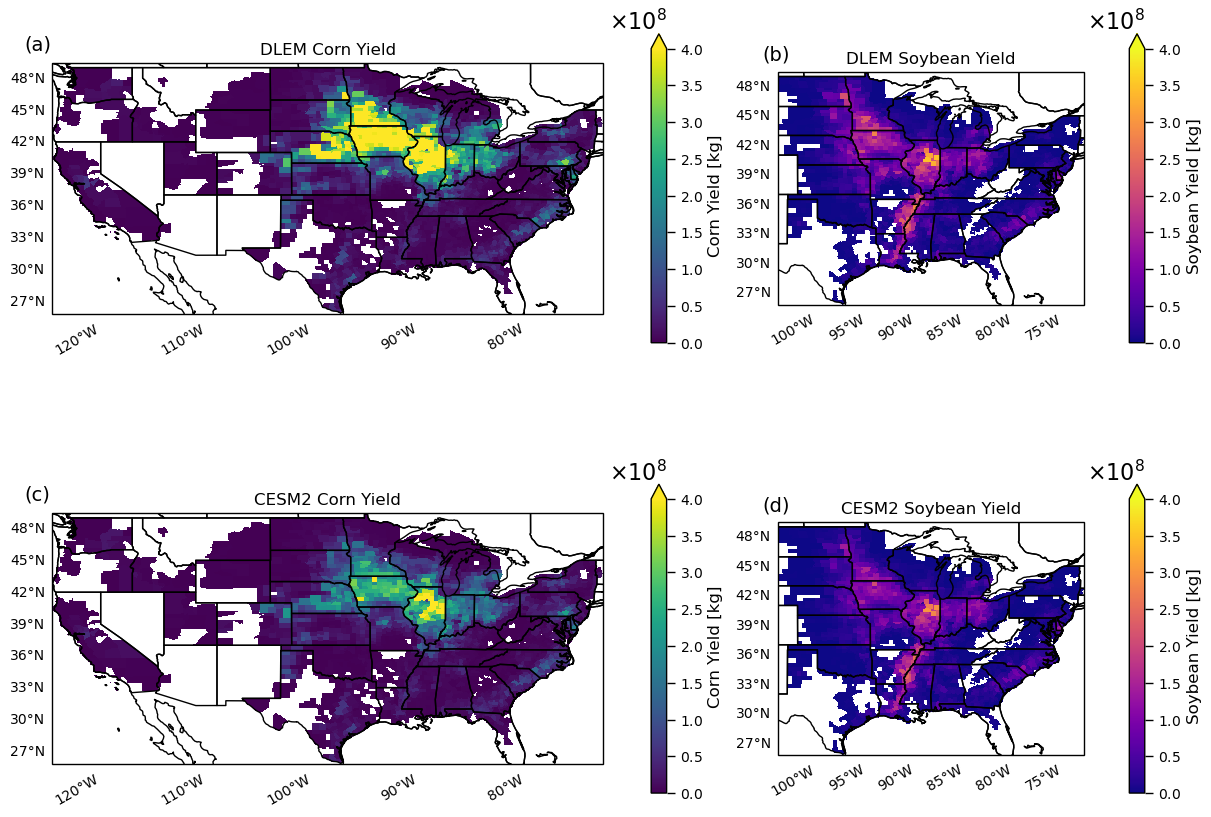

In [82]:
mean_corn = corn.mean('time')
mean_soybean = soybean.mean('time')
fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 2, width_ratios=[1.8, 1])
ax = np.array([
    [fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()), fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())],
    [fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree()), fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())],
])
im = mean_corn['DLEM'].plot(
    ax=ax[0,0], transform=ccrs.PlateCarree(), cmap='viridis', 
    add_colorbar=False, vmin=0, vmax=400000000
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='max', shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Corn Yield [kg]', fontsize=12)
im = mean_corn['CESM2'].plot(
    ax=ax[1, 0], transform=ccrs.PlateCarree(), cmap='viridis',
    add_colorbar=False, vmin=0, vmax=400000000
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='max', shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Corn Yield [kg]', fontsize=12)
im = mean_soybean['DLEM'].plot(
    ax=ax[0, 1], transform=ccrs.PlateCarree(), cmap='plasma',
    add_colorbar=False, vmin=0, vmax=400000000
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='max', shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Soybean Yield [kg]', fontsize=12)
im = mean_soybean['CESM2'].plot(
    ax=ax[1, 1], transform=ccrs.PlateCarree(), cmap='plasma', 
    add_colorbar=False, vmin=0, vmax=400000000
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='max', shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Soybean Yield [kg]', fontsize=12)
# Add titles to the plots
ax[0, 0].set_title('DLEM Corn Yield', fontsize=12)
ax[1, 0].set_title('CESM2 Corn Yield', fontsize=12)
ax[0, 1].set_title('DLEM Soybean Yield', fontsize=12)
ax[1, 1].set_title('CESM2 Soybean Yield', fontsize=12)

for n, ax in enumerate(ax.flat):
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
plt.savefig(fig_dir+'mean_production.png', dpi=300, bbox_inches='tight')
plt.show()

### Bias in mean production

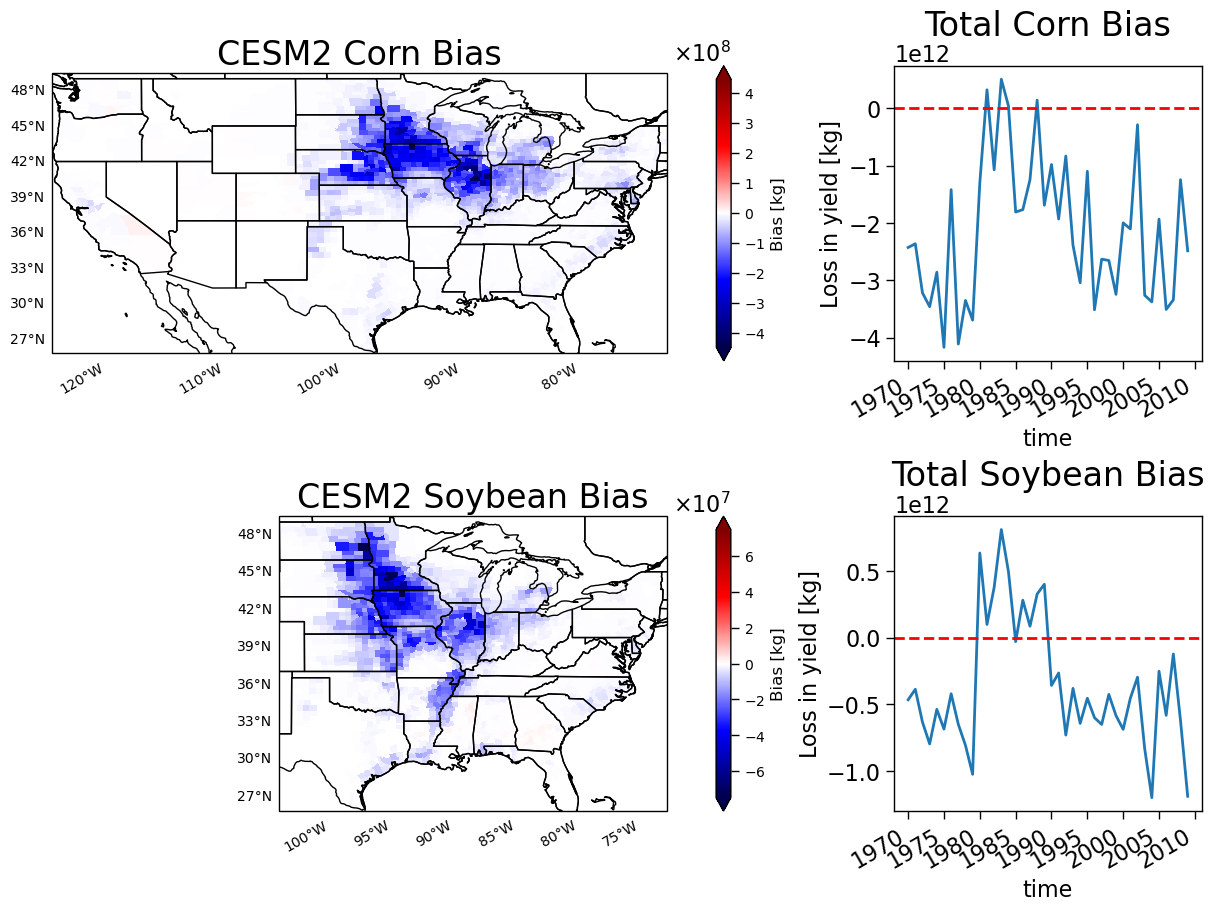

In [23]:
corn_bias = corn['CESM2']-corn['DLEM']
soybean_bias = soybean['CESM2']-soybean['DLEM']
fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = corn_bias.mean('time').plot(
    ax=ax1, transform=ccrs.PlateCarree(), cmap='seismic', 
    add_colorbar=False
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=1)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Bias [kg]', fontsize=12)
ax1.set_title('CESM2 Corn Bias', fontsize=24)
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = soybean_bias.mean('time').plot(
    ax=ax2, transform=ccrs.PlateCarree(), cmap='seismic',
    add_colorbar=False,
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=1)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Bias [kg]', fontsize=12)
ax2.set_title('CESM2 Soybean Bias', fontsize=24)
# Time series
ax = fig.add_subplot(gs[0, 1])
corn_bias.sum(['lat', 'lon']).plot(ax=ax)
ax.set_title('Total Corn Bias', fontsize=24)
ax.set_ylabel('Loss in yield [kg]')
ax.axhline(y=0, c='red', linestyle='--')
ax = fig.add_subplot(gs[1, 1])
soybean_bias.sum(['lat', 'lon']).plot(ax=ax)
ax.set_title('Total Soybean Bias', fontsize=24)
ax.set_ylabel('Loss in yield [kg]')
ax.axhline(y=0, c='red', linestyle='--')

for ax in [ax1, ax2]:
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
plt.savefig(fig_dir+'mean_bias.png', dpi=300, bbox_inches='tight')
plt.show()

## Production over time

Use the Kendall-Tau statistic because it is non-paremetric (no assumptions about distribution) and the relationship need not be linear.

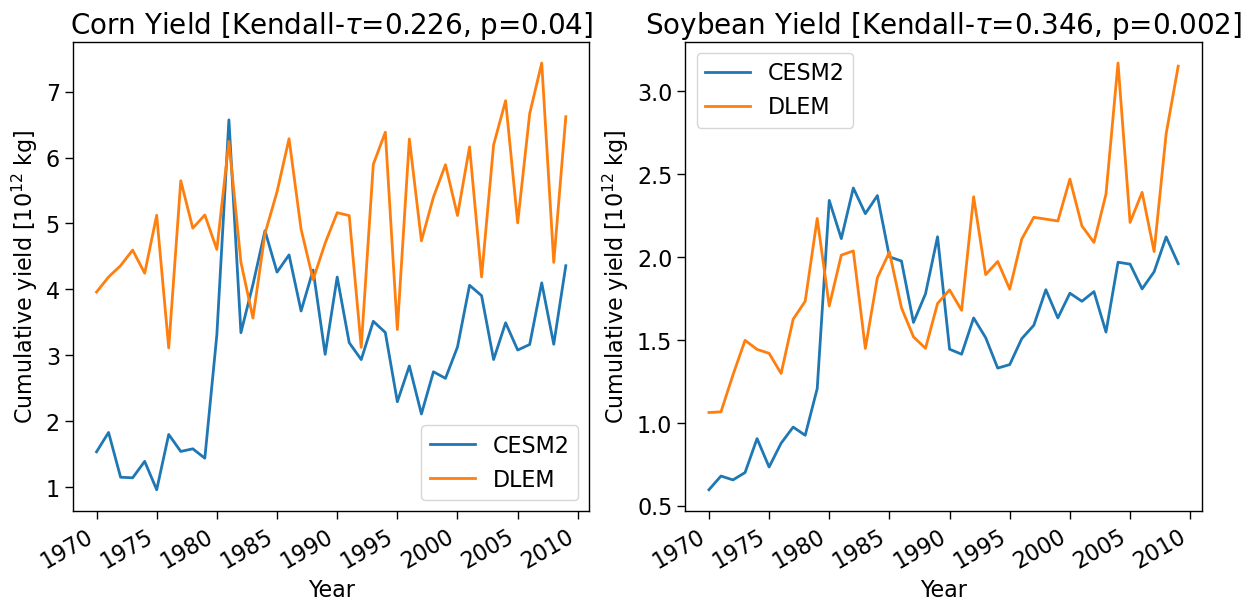

In [65]:
from scipy.stats import kendalltau
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax = np.array([fig.add_subplot(gs[0]), fig.add_subplot(gs[1])])
# Corn
(corn['CESM2'].sum(['lat', 'lon'])/10**12).plot(ax=ax[0], label='CESM2')
(corn['DLEM'].sum(['lat', 'lon'])/10**12).plot(ax=ax[0], label='DLEM')
k, p_val = kendalltau(corn['CESM2'].sum(['lat', 'lon']), corn['DLEM'].sum(['lat', 'lon']))
ax[0].legend()
ax[0].set_xlabel('Year')
ax[0].set_ylabel(r'Cumulative yield [$10^{12}$ kg]')
ax[0].set_title(r'Corn Yield [Kendall-$\tau$='+str(round(k, 3))+', p='+str(round(p_val, 3))+']', fontsize=20)
# Soybean
(soybean['CESM2'].sum(['lat', 'lon'])/10**12).plot(ax=ax[1], label='CESM2')
(soybean['DLEM'].sum(['lat', 'lon'])/10**12).plot(ax=ax[1], label='DLEM')
k, p_val = kendalltau(soybean['CESM2'].sum(['lat', 'lon']), soybean['DLEM'].sum(['lat', 'lon']))
ax[1].legend()
ax[1].set_xlabel('Year')
ax[1].set_ylabel(r'Cumulative yield [$10^{12}$ kg]')
ax[1].set_title(r'Soybean Yield [Kendall-$\tau$='+str(round(k, 3))+', p='+str(round(p_val, 3))+']', fontsize=20)
plt.savefig(fig_dir+'yield_over_time.png', dpi=300, bbox_inches='tight')
plt.show()


## Histogram

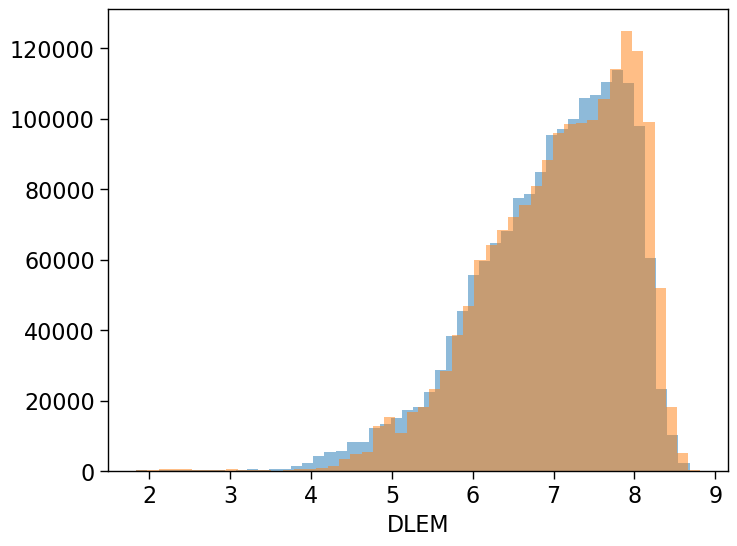

In [75]:
# np.log10(corn['CESM2']).plot(bins=50, alpha=0.5)
# np.log10(corn['DLEM']).plot(bins=50, alpha=0.5)
np.log10(soybean['CESM2']).plot(bins=50, alpha=0.5)
np.log10(soybean['DLEM']).plot(bins=50, alpha=0.5)
plt.show()